# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Load the Data/Filtering for Chosen Zipcodes

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('zillow_data.csv')

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [7]:
# grab single zip code
df_kc = df[df['RegionName'] == 64154]

In [10]:
df_kc.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
7553,86388,64154,Kansas City,MO,Kansas City,Jackson,7554,152600.0,152600.0,152700.0,...,251400,251000,251300,252000,252700,253800,255300,255400,254400,253300


# Reshape from Wide to Long Format

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro',
                                  'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [14]:
df_kc_melt = melt_data(df_kc)

In [16]:
df_kc_melt.head()

,value
time,
1996-04-01,152600.0
1996-05-01,152600.0
1996-06-01,152700.0
1996-07-01,152600.0
1996-08-01,152500.0


# ARIMA Modeling

Code from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [17]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_kc_melt.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=698619975.362
ARIMA(0, 0, 1) MSE=177608828.761
ARIMA(0, 1, 0) MSE=2455815.101
ARIMA(0, 1, 1) MSE=808446.950
ARIMA(0, 2, 0) MSE=970842.246
ARIMA(0, 2, 1) MSE=570941.374
ARIMA(1, 0, 0) MSE=2594919.032
ARIMA(1, 1, 0) MSE=905910.803
ARIMA(1, 1, 2) MSE=460998.553
ARIMA(1, 2, 0) MSE=845354.074
ARIMA(1, 2, 1) MSE=587116.766
ARIMA(2, 0, 0) MSE=908092.203
ARIMA(2, 0, 2) MSE=473204.596
ARIMA(2, 1, 0) MSE=674688.614
ARIMA(2, 1, 1) MSE=487286.821
ARIMA(2, 2, 0) MSE=594685.121
ARIMA(2, 2, 1) MSE=553099.020
ARIMA(4, 0, 0) MSE=555905.646
ARIMA(4, 0, 1) MSE=493092.103
ARIMA(4, 1, 0) MSE=515554.210
ARIMA(4, 1, 1) MSE=500990.802
ARIMA(4, 2, 0) MSE=535611.392
ARIMA(4, 2, 1) MSE=557813.722
ARIMA(6, 0, 0) MSE=496057.583
ARIMA(6, 1, 0) MSE=517435.187
ARIMA(6, 1, 1) MSE=523304.952
ARIMA(6, 2, 0) MSE=571501.081
ARIMA(6, 2, 1) MSE=580032.104
ARIMA(8, 0, 0) MSE=542156.856
ARIMA(8, 0, 1) MSE=536064.481
ARIMA(8, 1, 0) MSE=524301.558
ARIMA(8, 1, 1) MSE=533516.086
ARIMA(8, 2, 0) MSE=567700.485
AR

# Step 6: Interpreting Results

In [20]:
# make foreacst 
model = ARIMA(df_kc_melt, order=(1,1,2))
model_fit = model.fit(disp=0)

In [21]:
forecast = model_fit.forecast(24)

In [25]:
actual_foreacst = forecast[0]
forecast_conf_int = forecast[2]

In [27]:
df_kc_melt.tail(2)

,value
time,
2018-03-01,254400.0
2018-04-01,253300.0


In [41]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

In [42]:
# combine raw data dataframe and forecast dataframe
df_new = pd.concat([df_kc_melt, df_forecast])

In [43]:
df_new.head()

,forecast,lower_bound,upper_bound,value
time,,,,
1996-04-01,NaN,NaN,NaN,152600.0
1996-05-01,NaN,NaN,NaN,152600.0
1996-06-01,NaN,NaN,NaN,152700.0
1996-07-01,NaN,NaN,NaN,152600.0
1996-08-01,NaN,NaN,NaN,152500.0


Text(0.5, 1.0, 'Forecast for 64154')

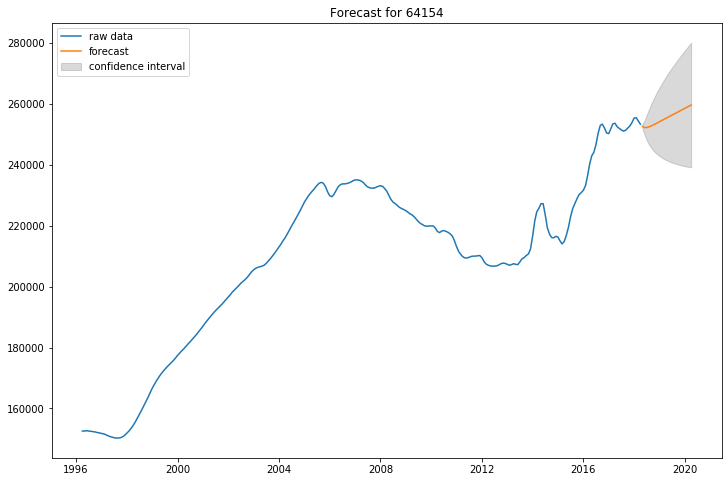

In [58]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_new['value'], label = 'raw data')
plt.plot(df_new['forecast'], label = 'forecast')
plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                label = 'confidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for 64154')

## Get Percent Change in House Price 

In [63]:
# forecasted price after 2 years
forcast_2_years = df_new.loc['2020-04-01', 'forecast']
forcast_lower = df_new.loc['2020-04-01', 'lower_bound']
forcast_upper = df_new.loc['2020-04-01', 'upper_bound']

In [66]:
last_price = df_kc_melt.loc['2018-04-01', 'value']

In [81]:
predicted_percent_change = (forcast_2_years - last_price) / last_price
print(f' I would expect a  {np.round(predicted_percent_change * 100, 4)}% return on my investment in 64154')

 I would expect a  2.4778% return on my investment in 64154


In [80]:
best_percent_change = (forcast_upper - last_price) / last_price
print(f'Best case scenario I would expect a  {np.round(best_percent_change * 100, 4)}% return on my investment in 64154')

Best case scenario I would expect a  10.5531% return on my investment in 64154


In [82]:
worst_percent_change = (forcast_lower - last_price) / last_price
print(f'Worst case scenario I would expect a  {np.round(worst_percent_change * 100, 4)}% return on my investment in 64154')

Worst case scenario I would expect a  -5.5975% return on my investment in 64154
